![DLI Header](images/DLI_Header.png)

# Token Classification with Large Language Models #

## 01 - Named Entity Recognition with Pre-Trained Model ##

In this notebook, you will learn to use a pre-trained token classification model. Specifically, we will use a model for named entity recognition. NER, also referred to as entity chunking, identification or extraction, is the task of detecting and classifying key information (entities) in text. In other words, a NER model takes a piece of text as input and for each word in the text, the model identifies a category the word belongs to. For example, in a sentence: `Mary lives in Santa Clara and works at NVIDIA`, the model should detect that `Mary` is a person, `Santa Clara` is a location and `NVIDIA` is a company.

**Table of Contents**<br>
This notebook covers the below sections: 
* Project Overview
* Dataset
    * Download and Preprocess data
    * Labeling Data (OPTIONAL)
* Use Pre-Trained Model
    * Download Model
    * Make Predictions
    * Model Evaluation
* Fine-Tune a Pre-Trained Model

## Project Overview ##

<img src='images/workflow.png' width=1080>

## Dataset ##
For this notebook, we're going to use the [GMB (Groningen Meaning Bank)](http://www.let.rug.nl/bjerva/gmb/about.php) corpus for named entity recognition. GMB is a fairly large corpus with a lot of annotations. The data is labeled using the [IOB format](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)) (short for inside, outside, beginning), which means each annotation also needs a prefix of **I**, **O**, or **B**. 

The following classes appear in the dataset:
* **LOC** - Geographical Entity
* **ORG** - Organization
* **PER** - Person
* **GPE** - Geopolitical Entity
* **TIME** - Time indicator
* **ART** - Artifact
* **EVE** - Event
* **NAT** - Natural Phenomenon

_Note:_ GMB is not completely human annotated, and it’s not considered 100% correct. For this exercise, classes **ART**, **EVE**, and **NAT** were combined into a **MISC** class due to small number of examples for these classes.

For token classification tasks, NeMo requires the data to be in a specific format. Data needs to be split into  files: 
* `text.txt` and 
* `labels.txt`

Each line of the **text.txt** file contains text sequences, where words are separated with spaces, i.e.: `[WORD] [SPACE] [WORD] [SPACE] [WORD]`. The **labels.txt** file contains corresponding labels for each word in **text.txt**, the labels are separated with spaces, i.e.: `[LABEL] [SPACE] [LABEL] [SPACE] [LABEL]`.

For example: 
* **text.txt**
```
Jennifer is from New York City .
She likes ...
...
```
* **labels.txt**
```
B-PER O O B-LOC I-LOC I-LOC O
O O ...
...
```

### Download and Preprocess Data ###

In [1]:
import os
import wget

# set data path
DATA_DIR="data/GMB"

In [2]:
# check that data folder should contain 4 files
!ls -l $DATA_DIR

total 11140
-rw-r--r-- 1 root root      77 Jul  5 07:47 label_ids.csv
-rw-r--r-- 1 root root  407442 Jul  5 07:47 labels_dev.txt
-rw-r--r-- 1 root root 3169783 Jul  5 07:47 labels_train.txt
-rw-r--r-- 1 root root  891020 Jul  5 07:47 text_dev.txt
-rw-r--r-- 1 root root 6928251 Jul  5 07:47 text_train.txt


In [3]:
# preview data 
print('Text:')
!head -n 5 {DATA_DIR}/text_train.txt

print('Labels:')
!head -n 5 {DATA_DIR}/labels_train.txt

Text:
New Zealand 's cricket team has scored a morale-boosting win over Bangladesh in the first of three one-day internationals in New Zealand .
Despite Bangladesh 's highest total ever in a limited-overs match , the Kiwis were able to win the match by six wickets in Auckland .
Opening batsman Jamie How led all scorers with 88 runs as New Zealand reached 203-4 in 42.1 overs .
The score was in response to Bangladesh 's total of 201 all out in 46.3 overs .
Mohammad Ashraful led the visitors with 70 runs , including 10 fours and one six on the short boundaries of the Eden Park ground .
Labels:
B-LOC I-LOC O O O O O O O O O B-LOC O O B-TIME I-TIME I-TIME I-TIME O O B-LOC I-LOC O
O B-LOC O O O O O O O O O O B-GPE O O O O O O O O O O B-LOC O
O O B-PER I-PER O O O O O O O B-LOC I-LOC O O O O O O
O O O O O O B-LOC O O O O O O O O O O
B-PER I-PER O O O O O O O O O O O O O O O O O O O B-LOC I-LOC O O


### Labeling Data ###

If you have raw data, NeMo recommends using the [Datasaur](https://datasaur.ai/) labeling platform to apply labels to data. Datasaur was designed specifically for labeling text data and supports basic NLP labeling tasks such as Named Entity Recognition and text classification through advanced NLP tasks such as dependency parsing and coreference resolution. You can sign up for Datasaur for free at https://datasaur.ai/sign-up/. Once you upload a file, you can choose from multiple NLP project types and use the Datasaur interface to label the data. After labeling, you can export the labeled data using the conll_2003 format, which integrates directly with NeMo. A video walkthrough can be found [here](https://www.youtube.com/watch?v=I9WVmnnSciE).

## Use Pre-Trained Model ##
NeMo supports NER and other token-level classification tasks. These models typically comprise of a pre-trained [BERT](https://arxiv.org/pdf/1810.04805.pdf) model followed by a token classification layer. We start by using a pre-trained model. The `TokenClassificationModel` inherits from `NLPModel` and has the below methods: 
* `TokenClassificationModel.add_predictions()`
* `TokenClassificationModel.evaluate_from_file()`

These are useful when making inference and evaluating model performance. Additional functionality of the `TokenClassificationModel` can be found in the [source code](https://github.com/NVIDIA/NeMo/blob/main/nemo/collections/nlp/models/token_classification/token_classification_model.py). 

### Download Pre-Trained Model ###

In [4]:
# import dependencies
from nemo.collections.nlp.models import TokenClassificationModel

# list available pre-trained models
for model in TokenClassificationModel.list_available_models():
    print(model)

NOTE! Installing ujson may make loading annotations faster.
PretrainedModelInfo(
	pretrained_model_name=ner_en_bert,
	description=The model was trained on GMB (Groningen Meaning Bank) corpus for entity recognition and achieves 74.61 F1 Macro score.,
	location=https://api.ngc.nvidia.com/v2/models/nvidia/nemo/ner_en_bert/versions/1.10/files/ner_en_bert.nemo
)


_Note:_ These are models trained for token classification. To get a list of all supported models, use `nemo.collections.nlp.modules.get_pretrained_lm_models_list(include_external=True)`. The list of pre-trained models is expected to change as they become available. 

In [5]:
# download and load the pre-trained BERT-based model
pretrained_ner_model=TokenClassificationModel.from_pretrained("ner_en_bert")

[NeMo I 2024-07-05 07:49:30 cloud:68] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/ner_en_bert/versions/1.10/files/ner_en_bert.nemo to /root/.cache/torch/NeMo/NeMo_1.20.0/ner_en_bert/8186f86c83b11d70b43b9ead695e7eda/ner_en_bert.nemo
[NeMo I 2024-07-05 07:49:35 common:913] Instantiating model from pre-trained checkpoint
[NeMo I 2024-07-05 07:49:38 tokenizer_utils:130] Getting HuggingFace AutoTokenizer with pretrained_model_name: bert-base-uncased, vocab_file: /tmp/tmpfs99p_je/tokenizer.vocab_file, merges_files: None, special_tokens_dict: {}, and use_fast: False


Using eos_token, but it is not set yet.
Using bos_token, but it is not set yet.
[NeMo W 2024-07-05 07:49:38 modelPT:244] You tried to register an artifact under config key=tokenizer.vocab_file but an artifact for it has already been registered.
[NeMo W 2024-07-05 07:49:38 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    text_file: text_train.txt
    labels_file: labels_train.txt
    shuffle: true
    num_samples: -1
    batch_size: 64
    
[NeMo W 2024-07-05 07:49:38 modelPT:168] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    text_file: text_dev.txt
    labels_file: labels_dev.txt
    shuffle: false
    num_samples: -1
    batch_size: 64
    

[NeMo W 2024-07-05 07:49:41 modelPT:244] You tried to register an artifact under config key=language_model.config_file but an artifact for it has already been registered.


[NeMo I 2024-07-05 07:49:42 save_restore_connector:249] Model TokenClassificationModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.20.0/ner_en_bert/8186f86c83b11d70b43b9ead695e7eda/ner_en_bert.nemo.


### Make Predictions ###

In [6]:
# define the list of queries for inference
queries=[
    'we bought four shirts from the nvidia gear store in santa clara.',
    'Nvidia is a company.',
]

# make sample predictions
results=pretrained_ner_model.add_predictions(queries)

# show predictions
for query, result in zip(queries, results):
    print(f'Query : {query}')
    print(f'Result: {result.strip()}\n')
    print()

[NeMo I 2024-07-05 07:49:42 token_classification_dataset:123] Setting Max Seq length to: 17
[NeMo I 2024-07-05 07:49:42 data_preprocessing:404] Some stats of the lengths of the sequences:
[NeMo I 2024-07-05 07:49:42 data_preprocessing:406] Min: 9 |                  Max: 17 |                  Mean: 13.0 |                  Median: 13.0
[NeMo I 2024-07-05 07:49:42 data_preprocessing:412] 75 percentile: 15.00
[NeMo I 2024-07-05 07:49:42 data_preprocessing:413] 99 percentile: 16.92


[NeMo W 2024-07-05 07:49:42 token_classification_dataset:152] 0 are longer than 17


[NeMo I 2024-07-05 07:49:42 token_classification_dataset:155] *** Example ***
[NeMo I 2024-07-05 07:49:42 token_classification_dataset:156] i: 0
[NeMo I 2024-07-05 07:49:42 token_classification_dataset:157] subtokens: [CLS] we bought four shirts from the n ##vid ##ia gear store in santa clara . [SEP]
[NeMo I 2024-07-05 07:49:42 token_classification_dataset:158] loss_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[NeMo I 2024-07-05 07:49:42 token_classification_dataset:159] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[NeMo I 2024-07-05 07:49:42 token_classification_dataset:160] subtokens_mask: 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0
Query : we bought four shirts from the nvidia gear store in santa clara.
Result: we bought four shirts from the nvidia[B-ORG] gear store in santa[B-LOC] clara[I-LOC].


Query : Nvidia is a company.
Result: Nvidia[B-ORG] is a company.




### Evaluate Predictions ###

To see how the model performs, we can generate predictions similar to the way we did it before and compare it with the labels. Alternatively, the `evaluate_from_file()` method enables us to evaluate the model given `text_file` and `labels_file`. Optionally, you can use the `add_confusion_matrix` to get a visual representation of the model performance. 

In [7]:
# create a subset of our dev data
!head -n 100 $DATA_DIR/text_dev.txt > $DATA_DIR/sample_text_dev.txt
!head -n 100 $DATA_DIR/labels_dev.txt > $DATA_DIR/sample_labels_dev.txt

Now, let's generate predictions for the provided text file. If labels file is also specified, the model will evaluate the predictions and plot confusion matrix.

[NeMo I 2024-07-05 07:49:43 token_classification_dataset:123] Setting Max Seq length to: 70
[NeMo I 2024-07-05 07:49:43 data_preprocessing:404] Some stats of the lengths of the sequences:
[NeMo I 2024-07-05 07:49:43 data_preprocessing:406] Min: 11 |                  Max: 70 |                  Mean: 26.9 |                  Median: 26.0
[NeMo I 2024-07-05 07:49:43 data_preprocessing:412] 75 percentile: 33.00
[NeMo I 2024-07-05 07:49:43 data_preprocessing:413] 99 percentile: 65.05


[NeMo W 2024-07-05 07:49:43 token_classification_dataset:152] 0 are longer than 70


[NeMo I 2024-07-05 07:49:43 token_classification_dataset:155] *** Example ***
[NeMo I 2024-07-05 07:49:43 token_classification_dataset:156] i: 0
[NeMo I 2024-07-05 07:49:43 token_classification_dataset:157] subtokens: [CLS] hamas refuses to recognize israel , and has vowed to undermine palestinian leader mahmoud abbas ' s efforts to make peace with the jewish state . [SEP]
[NeMo I 2024-07-05 07:49:43 token_classification_dataset:158] loss_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2024-07-05 07:49:43 token_classification_dataset:159] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2024-07-05 07:49:43 token_classification_dataset:160] subtokens_mask: 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

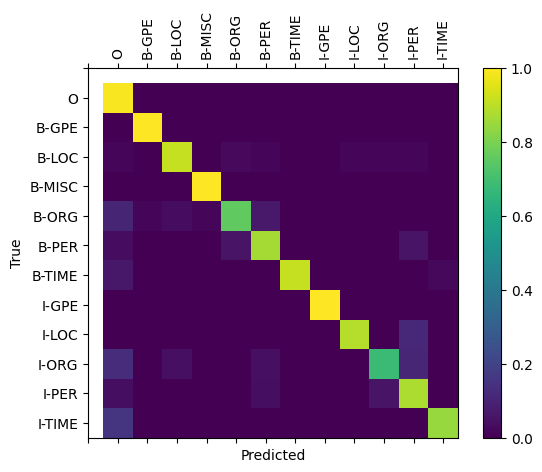

In [8]:
WORK_DIR = "WORK_DIR"

# evaluate model performance on sample
pretrained_ner_model.evaluate_from_file(
    text_file=os.path.join(DATA_DIR, 'sample_text_dev.txt'),
    labels_file=os.path.join(DATA_DIR, 'sample_labels_dev.txt'),
    output_dir=WORK_DIR,
    add_confusion_matrix=True,
    normalize_confusion_matrix=True,
    batch_size=1
)

## Fine-Tune a Pre-Trained Model ##

Without specifying configuration file, NeMo will use the default configurations for the model and trainer. When fine-tuning a pre-trained NER model, we need to setup training and evaluation data before training, the dataset directory is the only required argument if the files names are `labels_dev.txt`, `labels_train.txt`, `text_dev.txt`, and `text_train.txt`. 

In [9]:
import pytorch_lightning as pl

# setup the data dir to get class weights statistics
pretrained_ner_model.update_data_dir(DATA_DIR)

# setup train and validation Pytorch DataLoaders
pretrained_ner_model.setup_training_data()
pretrained_ner_model.setup_validation_data()

[NeMo I 2024-07-05 07:49:45 token_classification_model:84] Setting model.dataset.data_dir to data/GMB.
[NeMo I 2024-07-05 07:49:45 token_classification_utils:118] Processing data/GMB/labels_train.txt
[NeMo I 2024-07-05 07:49:45 token_classification_utils:138] Using provided labels mapping {'O': 0, 'B-GPE': 1, 'B-LOC': 2, 'B-MISC': 3, 'B-ORG': 4, 'B-PER': 5, 'B-TIME': 6, 'I-GPE': 7, 'I-LOC': 8, 'I-MISC': 9, 'I-ORG': 10, 'I-PER': 11, 'I-TIME': 12}
[NeMo I 2024-07-05 07:49:45 token_classification_utils:154] Labels mapping {'O': 0, 'B-GPE': 1, 'B-LOC': 2, 'B-MISC': 3, 'B-ORG': 4, 'B-PER': 5, 'B-TIME': 6, 'I-GPE': 7, 'I-LOC': 8, 'I-MISC': 9, 'I-ORG': 10, 'I-PER': 11, 'I-TIME': 12} saved to : data/GMB/label_ids.csv
[NeMo I 2024-07-05 07:49:59 token_classification_utils:163] Three most popular labels in data/GMB/labels_train.txt:
[NeMo I 2024-07-05 07:49:59 data_preprocessing:194] label: 0, 1014899 out of 1199472 (84.61%).
[NeMo I 2024-07-05 07:49:59 data_preprocessing:194] label: 2, 43529 ou

[NeMo W 2024-07-05 07:51:32 token_classification_dataset:152] 1 are longer than 128


[NeMo I 2024-07-05 07:51:32 token_classification_dataset:155] *** Example ***
[NeMo I 2024-07-05 07:51:32 token_classification_dataset:156] i: 0
[NeMo I 2024-07-05 07:51:32 token_classification_dataset:157] subtokens: [CLS] new zealand ' s cricket team has scored a morale - boost ##ing win over bangladesh in the first of three one - day internationals in new zealand . [SEP]
[NeMo I 2024-07-05 07:51:32 token_classification_dataset:158] loss_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2024-07-05 07:51:32 token_classification_dataset:159] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

[NeMo W 2024-07-05 07:51:46 token_classification_dataset:152] 0 are longer than 79


[NeMo I 2024-07-05 07:51:46 token_classification_dataset:155] *** Example ***
[NeMo I 2024-07-05 07:51:46 token_classification_dataset:156] i: 0
[NeMo I 2024-07-05 07:51:46 token_classification_dataset:157] subtokens: [CLS] hamas refuses to recognize israel , and has vowed to undermine palestinian leader mahmoud abbas ' s efforts to make peace with the jewish state . [SEP]
[NeMo I 2024-07-05 07:51:46 token_classification_dataset:158] loss_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2024-07-05 07:51:46 token_classification_dataset:159] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2024-07-05 07:51:46 token_classification_dataset:160] subtokens_mask: 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [10]:
# set up loss
pretrained_ner_model.setup_loss()

CrossEntropyLoss()

_Note:_ Use `class_balancing='weighted_loss'` if you want to add class weights to the `CrossEntropyLoss`. 

In [11]:
# create a PyTorch Lightning trainer and call `fit` again
fast_dev_run=True
trainer=pl.Trainer(devices=1, accelerator='gpu', fast_dev_run=fast_dev_run)
trainer.fit(pretrained_ner_model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[NeMo I 2024-07-05 07:51:46 modelPT:721] Optimizer config = Adam (
    Parameter Group 0
        amsgrad: False
        betas: (0.9, 0.999)
        capturable: False
        differentiable: False
        eps: 1e-08
        foreach: None
        fused: None
        lr: 5e-05
        maximize: False
        weight_decay: 0.0
    )
[NeMo I 2024-07-05 07:51:46 lr_scheduler:910] Scheduler "<nemo.core.optim.lr_scheduler.WarmupAnnealing object at 0x7fe363fa8940>" 
    will be used during training (effective maximum steps = 1) - 
    Parameters : 
    (warmup_steps: null
    warmup_ratio: 0.1
    last_epoch: -1
    max_steps: 1
    )



  | Name                  | Type                 | Params
---------------------------------------------------------------
0 | bert_model            | BertEncoder          | 109 M 
1 | classifier            | TokenClassifier      | 600 K 
2 | loss                  | CrossEntropyLoss     | 0     
3 | classification_report | ClassificationReport | 0     
---------------------------------------------------------------
110 M     Trainable params
0         Non-trainable params
110 M     Total params
440.331   Total estimated model params size (MB)
[NeMo W 2024-07-05 07:51:46 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
      rank_zero_warn(
    
[NeMo 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_steps=1` reached.


_Note:_ When training a model, we can set up the model (and trainer) using a configuration file. This is not needed since the task we are performing is the same as the pre-trained model. We will train a custom token classification model in the next notebook, which will require using a configuration file. Furthermore, we are setting `fast_dev_run` to `True` for this demonstration so the trainer will run 1 training batch and 1 validation batch. For actual model training, disable the flag. 

[NeMo I 2024-07-05 07:51:48 token_classification_dataset:123] Setting Max Seq length to: 70
[NeMo I 2024-07-05 07:51:48 data_preprocessing:404] Some stats of the lengths of the sequences:
[NeMo I 2024-07-05 07:51:48 data_preprocessing:406] Min: 11 |                  Max: 70 |                  Mean: 26.9 |                  Median: 26.0
[NeMo I 2024-07-05 07:51:48 data_preprocessing:412] 75 percentile: 33.00
[NeMo I 2024-07-05 07:51:48 data_preprocessing:413] 99 percentile: 65.05


[NeMo W 2024-07-05 07:51:48 token_classification_dataset:152] 0 are longer than 70


[NeMo I 2024-07-05 07:51:48 token_classification_dataset:155] *** Example ***
[NeMo I 2024-07-05 07:51:48 token_classification_dataset:156] i: 0
[NeMo I 2024-07-05 07:51:48 token_classification_dataset:157] subtokens: [CLS] hamas refuses to recognize israel , and has vowed to undermine palestinian leader mahmoud abbas ' s efforts to make peace with the jewish state . [SEP]
[NeMo I 2024-07-05 07:51:48 token_classification_dataset:158] loss_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2024-07-05 07:51:48 token_classification_dataset:159] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2024-07-05 07:51:48 token_classification_dataset:160] subtokens_mask: 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

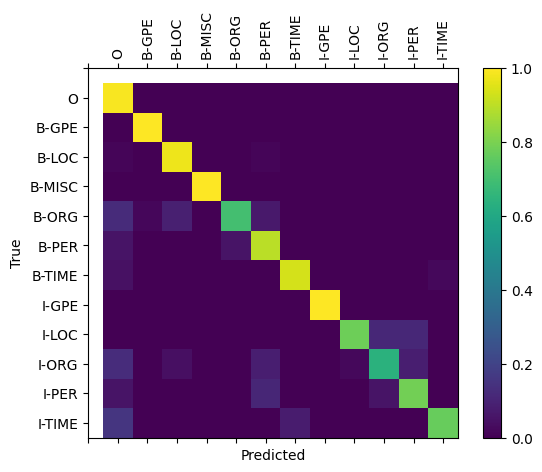

In [12]:
# evaluate model performance on sample
pretrained_ner_model.evaluate_from_file(
    text_file=os.path.join(DATA_DIR, 'sample_text_dev.txt'),
    labels_file=os.path.join(DATA_DIR, 'sample_labels_dev.txt'),
    output_dir=WORK_DIR,
    add_confusion_matrix=True,
    normalize_confusion_matrix=True,
    batch_size=1
)

In [13]:
# restart the kernel
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

**Well Done!** When you're ready, let's move to the [next notebook](./02_domain-specific_token_classification_model.ipynb).

![DLI Header](images/DLI_Header.png)